In [ ]:
#@title Install Necessary Modules
!pip install optuna
!pip install ucimlrepo
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 3.6 MB/s eta 0:00:00


In [ ]:
#@title Import Necessary Modules
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
import matplotlib.pyplot as plt
from scipy.stats import loguniform, randint
from sklearn.preprocessing import StandardScaler

import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, DotProduct, Matern

In [ ]:
#@title Code to import from google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#@title Import Data Red Portuguese "Vinho Verde" wine data
myfile = "/content/drive/MyDrive/Colab Notebooks/DS 397/Machine Problem 2/winequality-red.csv"
df  = pd.read_csv(myfile, delimiter=";")

#import data from local machine
# df = pd.read_csv("winequality-red.csv")
print(f"Shape of the data: {df.shape}")

Shape of the data: (1599, 12)


In [ ]:
#@title Extract Necessary Data, Split Dataset and Normalize
from sklearn.preprocessing import StandardScaler
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

#Standardize data only for the X data
# X_train_mean = np.mean(X_train, axis=0)
# X_train_std = np.std(X_train, axis=0)
# X_train_scaled = (X_train - X_train_mean) / X_train_std
# X_test_scaled = (X_test - X_train_mean) / X_train_std

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

N_train = X_train_scaled.shape[0]
N_test = X_test_scaled.shape[0]

In [ ]:
y_train.shape[0]

1119

# Optuna 2a

Apply Optuna to find the best model that you can for predicting the wine quality as a regression problem (the target is treated as continuous values from 0 to 10). You are free to design your own hyper-parameter search space and model search space. Report the MSE and R2 on thetraining and test set. Are your results better than the ones reported in the following paper? https://www.sciencedirect.com/science/article/pii/S0167923609001377

In [ ]:
#@title Train Optuna Model 1
def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['KRR', 'kNN', 'SVR', 'MLP', 'RF', 'GBR', 'GPR'])

    if model_type == 'KRR':
        alpha = trial.suggest_float('KRR_alpha',0.01, 100, log=True)
        kernel = trial.suggest_categorical('KRR_kernel',
                                           ['rbf', 'polynomial', 'cosine', 'laplacian', 'sigmoid'])
        model = KernelRidge(alpha=alpha, kernel=kernel)

    if model_type == 'kNN':
        wts = trial.suggest_categorical('kNN_weights', ['uniform', 'distance'])
        n_neigh = trial.suggest_int('kNN_n_neighbors',1,20)
        model = KNeighborsRegressor(weights=wts,n_neighbors=n_neigh)

    if model_type == 'SVR':
        kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        C = trial.suggest_float('SVR-C', 0.1, 100, log=True)
        gamma = trial.suggest_float('SVR-gamma', 0.1, 100, log=True)
        epsi = trial.suggest_float('SVR-epsilon', 0.1, 100, log=True)
        degree = trial.suggest_int('SVR-degree', 1, 3, step=1)
        model = SVR(kernel=kernel, C=C, epsilon=epsi, gamma=gamma, degree=degree)

    if model_type == 'MLP':
        params = {
                    'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.01, 0.5, log=True),
                    'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
                    'first_layer_neurons': trial.suggest_int('first_layer_neurons', 25, 150, step=1),
                    'second_layer_neurons': trial.suggest_int('second_layer_neurons', 15, 200, step=1),
                    'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
                    'alpha': trial.suggest_float('alpha', 0.0001, 1, log=True)
                 }

        model = MLPRegressor(hidden_layer_sizes=(params['first_layer_neurons'],
                                                 params['second_layer_neurons']),
                             learning_rate_init=params['learning_rate_init'],
                             learning_rate=params['learning_rate'],
                             activation=params['activation'],
                             alpha=params['alpha'],
                             max_iter=500,
                             random_state=42)

    if model_type == 'RF':
        n_estimators = trial.suggest_int('RF_n_estimators',10,200)
        max_depth = trial.suggest_int('RF_max_depth',1,50)
        min_samples_leaf = trial.suggest_int('RF_min_samples_leaf',1,10)
        min_samples_split = trial.suggest_int('RF_min_samples_split',2,10)
        crit = trial.suggest_categorical('RF_criterion', ['friedman_mse', 'squared_error', 'absolute_error'])
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      criterion=crit,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split,
                                      random_state=42)

    if model_type == 'GBR':
        n_estimators = trial.suggest_int('GBR_n_estimators',10,200)
        max_depth = trial.suggest_int('GBR_max_depth',1,50)
        min_samples_leaf = trial.suggest_int('GBR_min_samples_leaf',1,10)
        min_samples_split = trial.suggest_int('GBR_min_samples_split',2,10)
        learning_rate = trial.suggest_float('GBR_learning_rate', 0.01, 0.1, log=True)
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          learning_rate=learning_rate,
                                          min_samples_leaf=min_samples_leaf,
                                          min_samples_split=min_samples_split)

    if model_type == 'GPR':
        alpha = trial.suggest_float('GPR_alpha',0.01, 100, log=True)
        noise_level = trial.suggest_float('GPR_noise',0.01, 10, log=True)
        kernel_type = trial.suggest_categorical('GPR_kernel', ['rbf','matern','dot'])
        if kernel_type == 'rbf':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + RBF(length_scale=length_scale),
                                             alpha=alpha,
                                             normalize_y=False,
                                             n_restarts_optimizer=10)
        if kernel_type == 'matern':
            length_scale = trial.suggest_float('GPR_length_scale',0.01, 10, log=True)
            nu = trial.suggest_float('GP_nu',0.5, 5, step=0.5)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + Matern(length_scale=length_scale,nu=nu),
                                             alpha=alpha,
                                             normalize_y=False,
                                             n_restarts_optimizer=10)
        if kernel_type == 'dot':
            sigma = trial.suggest_float('GPR_dot_sigma', 0, 10)
            model = GaussianProcessRegressor(kernel=WhiteKernel(noise_level) + DotProduct(sigma_0=sigma),
                                             alpha=alpha,
                                             normalize_y=False,
                                             n_restarts_optimizer=10)

    if trial.should_prune():
            raise optuna.TrialPruned()

    return model

def objective(trial):
    model = create_model(trial)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                             cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize',
                            sampler=sampler)
optuna_start = time()
study.optimize(lambda trial: objective(trial), n_trials=100)
best_params = study.best_params
print("\n\nBest parameters: ", best_params)
total_time = time()-optuna_start
print("Runtime: %.4f sec" % total_time)
best_mdl = create_model(study.best_trial)

[I 2024-06-10 13:17:39,646] A new study created in memory with name: no-name-80c5db57-b501-4ccc-b7e8-2790fa03125c
[I 2024-06-10 13:17:39,685] Trial 0 finished with value: -0.5728415189693216 and parameters: {'model_type': 'kNN', 'kNN_weights': 'uniform', 'kNN_n_neighbors': 15}. Best is trial 0 with value: -0.5728415189693216.
[I 2024-06-10 13:17:39,723] Trial 1 finished with value: -0.5879118398106626 and parameters: {'model_type': 'kNN', 'kNN_weights': 'uniform', 'kNN_n_neighbors': 6}. Best is trial 0 with value: -0.5728415189693216.
[I 2024-06-10 13:17:45,594] Trial 2 finished with value: -0.4516760656520402 and parameters: {'model_type': 'GBR', 'GBR_n_estimators': 108, 'GBR_max_depth': 30, 'GBR_min_samples_leaf': 1, 'GBR_min_samples_split': 7, 'GBR_learning_rate': 0.014808945119975192}. Best is trial 2 with value: -0.4516760656520402.
[I 2024-06-10 13:17:45,621] Trial 3 finished with value: -0.6717809096732864 and parameters: {'model_type': 'SVR', 'kernel': 'rbf', 'SVR-C': 53.451661



Best parameters:  {'model_type': 'RF', 'RF_n_estimators': 189, 'RF_max_depth': 26, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'friedman_mse'}
Runtime: 2554.1767 sec


In [ ]:
#@title Train Optuna model 2

def create_model(trial):
    model_type = trial.suggest_categorical('model_type', ['MLP', 'RF', 'SVM', 'LGBM', 'XGB'])

    if model_type == 'MLP':
        params = {
                    'learning_rate_init': trial.suggest_float('learning_rate_init ', 0.01, 0.5, log=True),
                    'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
                    'first_layer_neurons': trial.suggest_int('first_layer_neurons', 25, 150, step=1),
                    'second_layer_neurons': trial.suggest_int('second_layer_neurons', 15, 200, step=1),
                    'activation': trial.suggest_categorical('activation', ['identity', 'tanh', 'relu']),
                    'alpha': trial.suggest_float('alpha', 0.0001, 1, log=True)
                 }

        model = MLPRegressor(hidden_layer_sizes=(params['first_layer_neurons'],
                                                 params['second_layer_neurons']),
                             learning_rate_init=params['learning_rate_init'],
                             learning_rate=params['learning_rate'],
                             activation=params['activation'],
                             alpha=params['alpha'],
                             max_iter=500,
                             random_state=42)
    if model_type == 'RF':
      n_estimators = trial.suggest_int('RF_n_estimators',10,200)
      max_depth = trial.suggest_int('RF_max_depth',1,50)
      min_samples_leaf = trial.suggest_int('RF_min_samples_leaf',1,10)
      min_samples_split = trial.suggest_int('RF_min_samples_split',2,10)
      crit = trial.suggest_categorical('RF_criterion', ['friedman_mse', 'squared_error', 'absolute_error'])
      model = RandomForestRegressor(n_estimators=n_estimators,
                                    criterion=crit,
                                    max_depth=max_depth,
                                    min_samples_leaf=min_samples_leaf,
                                    min_samples_split=min_samples_split,
                                    random_state=42)
    if model_type == 'SVM':
        C = trial.suggest_float('SVM-C', 0.1, 100, log=True)
        kernel = trial.suggest_categorical('SVM_kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
        degree = trial.suggest_int('SVM-degree', 1, 3, step=1)
        gamma = trial.suggest_float('SVM-gamma', 0.1, 100, log=True)
        epsi = trial.suggest_float('SVM-epsilon', 0.1, 100, log=True)
        model = SVR(kernel=kernel, C=C, epsilon=epsi, gamma=gamma, degree=degree)

    if model_type == 'LGBM':
        num_leaves = trial.suggest_int('LGBM_num_leaves', 2, 128)
        max_depth = trial.suggest_int('LGBM_max_depth', 1, 50)
        learning_rate = trial.suggest_float('LGBM_learning_rate', 0.01, 0.1, log=True)
        n_estimators = trial.suggest_int('LGBM_n_estimators', 10, 200)
        subsample = trial.suggest_float('LGBM_subsample', 0.5, 1, step=0.1)
        colsample_bytree = trial.suggest_float('LGBM_colsample_bytree', 0.5, 1, step=0.1)
        reg_alpha = trial.suggest_float('LGBM_reg_alpha', 0.01, 10, log=True)
        reg_lambda = trial.suggest_float('LGBM_reg_lambda', 0.01, 10, log=True)
        model = LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    if model_type == 'XGB':
        max_depth = trial.suggest_int('XGB_max_depth', 1, 50)
        learning_rate = trial.suggest_float('XGB_learning_rate', 0.01, 0.1, log=True)
        n_estimators = trial.suggest_int('XGB_n_estimators', 10, 200)
        gamma = trial.suggest_float('XGB_gamma', 0.01, 10, log=True)
        min_child_weight = trial.suggest_float('XGB_min_child_weight', 0.01, 10, log=True)
        subsample = trial.suggest_float('XGB_subsample', 0.5, 1, step=0.1)
        colsample_bytree = trial.suggest_float('XGB_colsample_bytree', 0.5, 1, step=0.1)
        reg_alpha = trial.suggest_float('XGB_reg_alpha', 0.01, 10, log=True)
        reg_lambda = trial.suggest_float('XGB_reg_lambda', 0.01, 10, log=True)
        model = XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators,
                              gamma=gamma, min_child_weight=min_child_weight, subsample=subsample,
                              colsample_bytree=colsample_bytree, reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    if trial.should_prune():
      raise optuna.TrialPruned()

    return model

def objective(trial):
    model = create_model(trial)
    scores = cross_val_score(model, X_train, y_train.ravel(),
                             cv=5, scoring='neg_mean_squared_error')
    return np.mean(scores)

sampler2 = TPESampler(seed=42)
study2 = optuna.create_study(direction='maximize',
                            sampler=sampler2)
optuna_start = time()
study2.optimize(lambda trial: objective(trial), n_trials=100)
best_params2 = study2.best_params
print("\n\nBest parameters: ", best_params2)
total_time = time()-optuna_start
print("Runtime: %.4f sec" % total_time)
best_mdl2 = create_model(study2.best_trial)


[I 2024-06-15 16:19:22,794] A new study created in memory with name: no-name-f40538a6-debc-428b-9783-2c04104a679f
[I 2024-06-15 16:19:27,116] Trial 0 finished with value: -0.5313853034613427 and parameters: {'model_type': 'RF', 'RF_n_estimators': 39, 'RF_max_depth': 3, 'RF_min_samples_leaf': 9, 'RF_min_samples_split': 7, 'RF_criterion': 'absolute_error'}. Best is trial 0 with value: -0.5313853034613427.
[I 2024-06-15 16:19:30,043] Trial 1 finished with value: -0.4792396334880764 and parameters: {'model_type': 'MLP', 'learning_rate_init ': 0.0779014312627624, 'learning_rate': 'adaptive', 'first_layer_neurons': 42, 'second_layer_neurons': 69, 'activation': 'relu', 'alpha': 0.0006290644294586153}. Best is trial 1 with value: -0.4792396334880764.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 945
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.623464
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing 

[I 2024-06-15 16:19:30,410] Trial 2 finished with value: -0.4144149353256708 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 10, 'LGBM_max_depth': 48, 'LGBM_learning_rate': 0.0923915031962725, 'LGBM_n_estimators': 164, 'LGBM_subsample': 0.6, 'LGBM_colsample_bytree': 0.5, 'LGBM_reg_alpha': 1.1290133559092674, 'LGBM_reg_lambda': 0.2091498132903561}. Best is trial 2 with value: -0.4144149353256708.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 11
[LightGBM] [Info] Start training from score 5.648438
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-06-15 16:19:31,053] Trial 3 finished with value: -0.4029045371313697 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 86, 'LGBM_max_depth': 16, 'LGBM_learning_rate': 0.03311829888072381, 'LGBM_n_estimators': 114, 'LGBM_subsample': 0.6, 'LGBM_colsample_bytree': 1.0, 'LGBM_reg_alpha': 2.1154290797261215, 'LGBM_reg_lambda': 6.58410616012161}. Best is trial 3 with value: -0.4029045371313697.
[I 2024-06-15 16:19:31,081] Trial 4 finished with value: -0.6717809096732864 and parameters: {'model_type': 'SVM', 'SVM-C': 0.13667272915456222, 'SVM_kernel': 'sigmoid', 'SVM-degree': 2, 'SVM-gamma': 0.6963114377829286, 'SVM-epsilon': 4.247058562261868}. Best is trial 3 with value: -0.4029045371313697.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-15 16:19:31,190] Trial 5 finished with value: -0.4318924855906886 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 27, 'LGBM_max_depth': 1, 'LGBM_learning_rate': 0.06538248584518043, 'LGBM_n_estimators': 145, 'LGBM_subsample': 0.9, 'LGBM_colsample_bytree': 0.9, 'LGBM_reg_alpha': 0.016677615430197915, 'LGBM_reg_lambda': 0.11895896737553548}. Best is trial 3 with value: -0.4029045371313697.
[I 2024-06-15 16:19:33,274] Trial 6 finished with value: -0.40220961617481504 and parameters: {'model_type': 'RF', 'RF_n_estimators': 69, 'RF_max_depth': 17, 'RF_min_samples_leaf': 8, 'RF_min_samples_split': 7, 'RF_criterion': 'friedman_mse'}. Best is trial 6 with value: -0.40220961617481504.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:19:33,587] Trial 7 finished with value: -0.5441302903126372 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 68, 'LGBM_max_depth': 22, 'LGBM_learning_rate': 0.010602764778958863, 'LGBM_n_estimators': 30, 'LGBM_subsample': 0.5, 'LGBM_colsample_bytree': 0.8, 'LGBM_reg_alpha': 0.08771380343280563, 'LGBM_reg_lambda': 0.33551510227214826}. Best is trial 6 with value: -0.40220961617481504.



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Fou

[I 2024-06-15 16:19:55,101] Trial 8 finished with value: -0.4747444691956029 and parameters: {'model_type': 'MLP', 'learning_rate_init ': 0.013514082247401422, 'learning_rate': 'adaptive', 'first_layer_neurons': 126, 'second_layer_neurons': 132, 'activation': 'identity', 'alpha': 0.3717371747825047}. Best is trial 6 with value: -0.40220961617481504.
[I 2024-06-15 16:19:55,452] Trial 9 finished with value: -0.6067797723673887 and parameters: {'model_type': 'SVM', 'SVM-C': 0.4828424974818325, 'SVM_kernel': 'rbf', 'SVM-degree': 2, 'SVM-gamma': 1.7874463256238415, 'SVM-epsilon': 0.46379219034580316}. Best is trial 6 with value: -0.40220961617481504.
[I 2024-06-15 16:19:58,948] Trial 10 finished with value: -0.38975520377836226 and parameters: {'model_type': 'RF', 'RF_n_estimators': 147, 'RF_max_depth': 33, 'RF_min_samples_leaf': 4, 'RF_min_samples_split': 4, 'RF_criterion': 'friedman_mse'}. Best is trial 10 with value: -0.38975520377836226.
[I 2024-06-15 16:20:04,843] Trial 11 finished wit

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:23:13,008] Trial 36 finished with value: -0.5759821609673079 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 126, 'LGBM_max_depth': 49, 'LGBM_learning_rate': 0.010849136690181008, 'LGBM_n_estimators': 28, 'LGBM_subsample': 1.0, 'LGBM_colsample_bytree': 0.5, 'LGBM_reg_alpha': 5.146031503941799, 'LGBM_reg_lambda': 0.010741014847253049}. Best is trial 17 with value: -0.38003055243580364.
[I 2024-06-15 16:23:19,314] Trial 37 finished with value: -0.38479312442179675 and parameters: {'model_type': 'RF', 'RF_n_estimators': 157, 'RF_max_depth': 41, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 3, 'RF_criterion': 'squared_error'}. Best is trial 17 with value: -0.38003055243580364.
[I 2024-06-15 16:23:20,155] Trial 38 finished with value: -0.47632037527167287 and parameters: {'model_type': 'XGB', 'XGB_max_depth': 43, 'XGB_learning_rate': 0.08091271906818132, 'XGB_n_estimators': 16, 'XGB_gamma': 9.004561259303735, 'XGB_min_child_weight': 7.428126073287583, 'XGB_sub

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:23:37,494] Trial 40 finished with value: -0.3900410487195226 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 128, 'LGBM_max_depth': 34, 'LGBM_learning_rate': 0.02666276611410138, 'LGBM_n_estimators': 200, 'LGBM_subsample': 0.8, 'LGBM_colsample_bytree': 0.7, 'LGBM_reg_alpha': 0.21544882246385091, 'LGBM_reg_lambda': 4.494589081630338}. Best is trial 17 with value: -0.38003055243580364.
[I 2024-06-15 16:23:44,017] Trial 41 finished with value: -0.38003055243580364 and parameters: {'model_type': 'RF', 'RF_n_estimators': 197, 'RF_max_depth': 46, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 17 with value: -0.38003055243580364.
[I 2024-06-15 16:23:50,288] Trial 42 finished with value: -0.3801426586542389 and parameters: {'model_type': 'RF', 'RF_n_estimators': 186, 'RF_max_depth': 46, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 17 with value: -0.3800305524

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-thre

[I 2024-06-15 16:24:28,463] Trial 48 finished with value: -0.4411431200417602 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 44, 'LGBM_max_depth': 3, 'LGBM_learning_rate': 0.022735484085508566, 'LGBM_n_estimators': 75, 'LGBM_subsample': 0.7, 'LGBM_colsample_bytree': 0.7, 'LGBM_reg_alpha': 0.010090810706559802, 'LGBM_reg_lambda': 0.015533970235047998}. Best is trial 43 with value: -0.37986441687976114.
[I 2024-06-15 16:24:34,854] Trial 49 finished with value: -0.38719419509739506 and parameters: {'model_type': 'RF', 'RF_n_estimators': 188, 'RF_max_depth': 47, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 9, 'RF_criterion': 'squared_error'}. Best is trial 43 with value: -0.37986441687976114.
[I 2024-06-15 16:24:36,200] Trial 50 finished with value: -0.3991690760966475 and parameters: {'model_type': 'RF', 'RF_n_estimators': 62, 'RF_max_depth': 42, 'RF_min_samples_leaf': 7, 'RF_min_samples_split': 4, 'RF_criterion': 'squared_error'}. Best is trial 43 with value: -0.379864416

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:26:09,156] Trial 70 finished with value: -0.39689955237717234 and parameters: {'model_type': 'LGBM', 'LGBM_num_leaves': 92, 'LGBM_max_depth': 34, 'LGBM_learning_rate': 0.04753151828163688, 'LGBM_n_estimators': 86, 'LGBM_subsample': 1.0, 'LGBM_colsample_bytree': 1.0, 'LGBM_reg_alpha': 0.07484405518481463, 'LGBM_reg_lambda': 0.8335081253090346}. Best is trial 52 with value: -0.37958514870456195.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 951
[LightGBM] [Info] Number of data points in the train set: 896, number of used features: 11
[LightGBM] [Info] Start training from score 5.648438
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:26:14,851] Trial 71 finished with value: -0.37958514870456195 and parameters: {'model_type': 'RF', 'RF_n_estimators': 192, 'RF_max_depth': 48, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:26:22,226] Trial 72 finished with value: -0.3797961945992755 and parameters: {'model_type': 'RF', 'RF_n_estimators': 191, 'RF_max_depth': 48, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:26:27,775] Trial 73 finished with value: -0.38151949407714636 and parameters: {'model_type': 'RF', 'RF_n_estimators': 190, 'RF_max_depth': 48, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 3, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:26:34,825] Trial 74 finished with value: -0.3850356247076828 and parameters: {'model_type'

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 947
[LightGBM] [Info] Number of data points in the train set: 895, number of used features: 11
[LightGBM] [Info] Start training from score 5.629050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-15 16:29:19,721] Trial 96 finished with value: -0.3932093679541131 and parameters: {'model_type': 'RF', 'RF_n_estimators': 183, 'RF_max_depth': 39, 'RF_min_samples_leaf': 5, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:29:26,718] Trial 97 finished with value: -0.3827596148476192 and parameters: {'model_type': 'RF', 'RF_n_estimators': 194, 'RF_max_depth': 49, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 5, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:29:32,070] Trial 98 finished with value: -0.38335315492410926 and parameters: {'model_type': 'RF', 'RF_n_estimators': 183, 'RF_max_depth': 45, 'RF_min_samples_leaf': 2, 'RF_min_samples_split': 3, 'RF_criterion': 'squared_error'}. Best is trial 52 with value: -0.37958514870456195.
[I 2024-06-15 16:29:39,574] Trial 99 finished with value: -0.5859539007272663 and parameters: {'model_type':



Best parameters:  {'model_type': 'RF', 'RF_n_estimators': 192, 'RF_max_depth': 48, 'RF_min_samples_leaf': 1, 'RF_min_samples_split': 2, 'RF_criterion': 'squared_error'}
Runtime: 616.7764 sec


In [ ]:
#@title Compute the Metrics Optuna Model 2
def compute_mse(X, y):
    scores_mse = cross_val_score(best_mdl2,
                                 X, y.ravel(),
                                 cv=5,
                                 scoring='neg_mean_squared_error')
    return -np.mean(scores_mse)

def compute_r2(X, y):
    scores_r2 = cross_val_score(best_mdl2,
                                X, y.ravel(),
                                cv=5,
                                scoring='r2')
    return np.mean(scores_r2)


best_mdl2.fit(X_train_scaled, y_train.ravel())

print("  Best cross-validation score (R2) : %.5f" % compute_r2(X_train_scaled, y_train))
print("  Best cross-validation score (MSE): %.5f" % compute_mse(X_train_scaled, y_train))
y_train_pred = best_mdl2.predict(X_train_scaled)
R2_train = r2_score(y_train,y_train_pred.ravel())
print("  Performance on train data (R2) :  %.5f" % R2_train)
mse_train = mean_squared_error(y_train,y_train_pred)
print("  Performance on train data (MSE):  %.5f" % mse_train)
y_test_pred = best_mdl2.predict(X_test)
R2_test = r2_score(y_test,y_test_pred.ravel())
print("  Performance on test data (R2)  :  %.5f" % R2_test)
mse_test = mean_squared_error(y_test,y_test_pred)
print("  Performance on test data (MSE) :  %.5f" % mse_test)

X = np.vstack((X_train_scaled, X_test_scaled))
y = np.vstack((y_train.to_numpy().reshape(-1,1), y_test.to_numpy().reshape(-1,1)))
y_pred = best_mdl2.predict(X)
R2_all = r2_score(y, y_pred)
print("  Performance on all data (R2)   :  %.5f" % R2_all)
mse_all = mean_squared_error(y, y_pred)
print("  Performance on all data (MSE)  :  %.5f" % mse_all)

  Best cross-validation score (R2) : 0.41326
  Best cross-validation score (MSE): 0.38082
  Performance on train data (R2) :  0.92316
  Performance on train data (MSE):  0.05019
  Performance on test data (R2)  :  -0.90786
  Performance on test data (MSE) :  1.23692
  Performance on all data (R2)   :  0.79473
  Performance on all data (MSE)  :  0.13379


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


Based on my results in comparison with (Cortez et. al.) the best model I have is Random Forest and on the results of the paper of Cortez et. al. their best model is SVM, in particular they worked in an R environment where they used RMiner to produce their empirical results. In my case I trained two different Optuna Models and both results says that the best model is Random Forest. In comparison of their results of Cortez et. al., I can say that Random Forest in terms of R2 metric overall the model explains about 79.47% of the variance in the target variable when considering all the data together. The MSE on all data combined is 0.13379, indicating a relatively small average squared difference between the actual and predicted values when considering all the data together.



From the paper: "Modeling wine preferences by data mining from physicochemical properties" by Cortez et. al. (2009). They used R-miner (a library for
the R tool that facilitates the use of DM techniques in classiﬁcation and
regression tasks) and the best model they have is SVM: And here are some of their results:

MAD: 0.46
Accuracy (tolerance = 0.25): 43.2%
Accuracy (tolerance = 0.50) 62.4%
Accuracy (tolerance = 1.00) 89.0%
Kappa (tolerance = 0.5) 38.7%



1.) MAD (Mean Absolute Deviation) is a measure of the average absolute errors between the predicted values and the actual values.


$\frac{1}{n} \sum_{i=1}^n |x_{i} - m(X) |$ ; $m(X)$ - average value of the data set; $n$ number of data values, $x_{i}$ - data values in a set

A lower MAD indicates better model performance because it means the predictions are closer to the actual values. Here, an MAD of 0.46 suggests that on average, the predicted wine quality scores deviate from the actual scores by 0.46 units.

2.) This metric shows the percentage of predictions that are within a tolerance range of 0.25 units from the actual value. An accuracy of 43.2% means that 43.2% of the predictions were within ±0.25 units of the true wine quality score.

3.) Tolerance = 0.50: An accuracy of 62.4% means that 62.4% of the predictions were within ±0.50 units of the actual wine quality score.

4.) Tolerance 1.00:  An accuracy of 89.0% means that 89.0% of the predictions were within ±1.00 units of the true wine quality score. This higher tolerance range typically results in a higher accuracy percentage.

5.) Cohen's Kappa is a statistic that measures inter-rater agreement for categorical items, adjusted for the agreement occurring by chance. In this context, it's adjusted for a tolerance range of 0.5 units. A Kappa value of 38.7% indicates a moderate level of agreement between the predicted and actual wine quality scores, considering the tolerance..

These results indicate that the SVM model used for predicting wine quality performs reasonably well, especially when a larger tolerance is allowed.





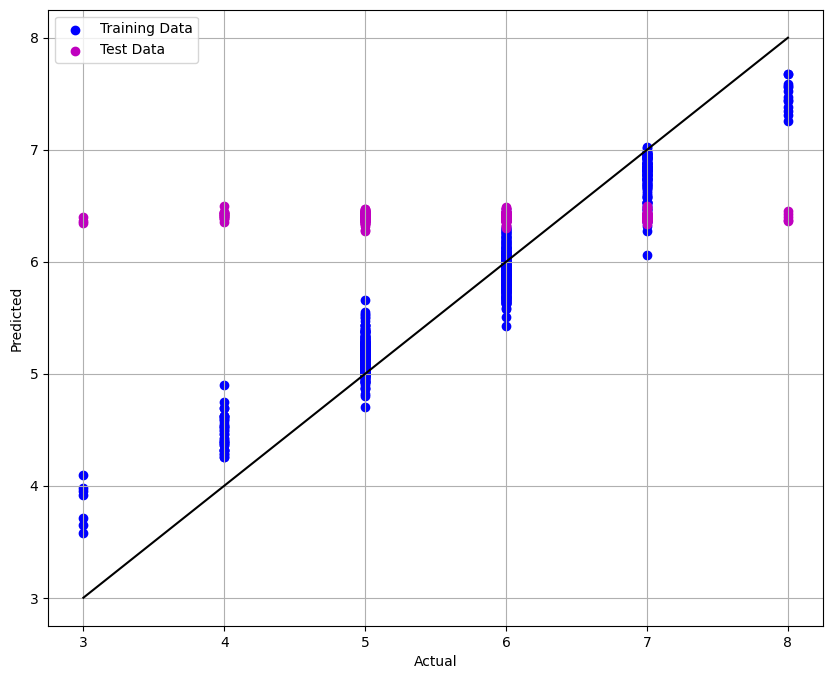

In [ ]:
#@title Plot of Actual and Predicted

# y_train_pred = scalerY.inverse_transform(y_train_pred.reshape(-1,1))
# y_test_pred = scalerY.inverse_transform(y_test_pred.reshape(-1,1))

y_lim = np.vstack((y_train.to_numpy().reshape(-1,1), y_test.to_numpy().reshape(-1,1),
                   y_train_pred.reshape(-1,1),
                   y_test_pred.reshape(-1,1)))
plt.figure(figsize=(10,8))
plt.plot(np.array([np.min(y_lim), np.max(y_lim)]),
         np.array([np.min(y_lim), np.max(y_lim)]), 'k')
plt.scatter(y_train, y_train_pred, color='b', label='Training Data')
plt.scatter(y_test, y_test_pred, color='m', label='Test Data')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.grid()
plt.show()

# Shapley 2b.)

Perform an explainability analysis on the best model in item (a) using Shapley values. Visualize the summary plot only. What insights can you gain from the result?

In [ ]:
#@title Display the needed Features
print(df.columns.values[np.r_[0:12]])
print(df.columns)
print(f"Data type for data.columns.values: {type(df.columns.values[np.r_[0:12]])}")

['fixed acidity' 'volatile acidity' 'citric acid' 'residual sugar'
 'chlorides' 'free sulfur dioxide' 'total sulfur dioxide' 'density' 'pH'
 'sulphates' 'alcohol' 'quality']
Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')
Data type for data.columns.values: <class 'numpy.ndarray'>


In [ ]:
#@title Shapley Values for Feature Importance
import shap

#Set the number of rows for X_train_scaled and number of samples

number_of_rows = 500;
number_of_samples = 100

# SHAP analysis
background = shap.sample(X_train_scaled, number_of_samples)
explainer = shap.KernelExplainer(best_mdl2.predict, background)
shap_values = explainer.shap_values(X_train_scaled[:number_of_rows])

  0%|          | 0/500 [00:00<?, ?it/s]

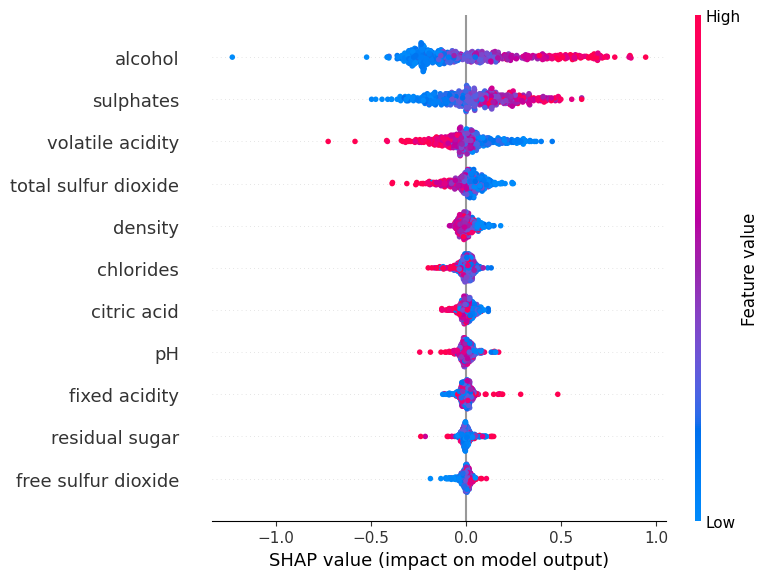

In [ ]:
#@title Plot the feature importance using SHAP
shap.summary_plot(shap_values, X_train_scaled[:number_of_rows], feature_names=df.columns.values[np.r_[0:12]])

Based on the summary plot above, we can see that among the features for the red wine dataset, alcohol has the highest impact while free sulfur dioxide has the lowest impact. For the Alcohol feature, higher values of alcohol increase the probability of higher quality for the red wine, and decreasing the alcohol content will also decrease the quality of the red wine. The second most important feature, based on what my SHAP analysis shows, is Sulphates. Lowering the value of Sulphates increases the probability of lower quality for the red wine, while increasing the Sulphate values also increases the probability of lower quality for the red wine. Similarly, for volatile acidity and total sulfur dioxide, decreasing their values or content increases the probability of higher quality for the red wine.

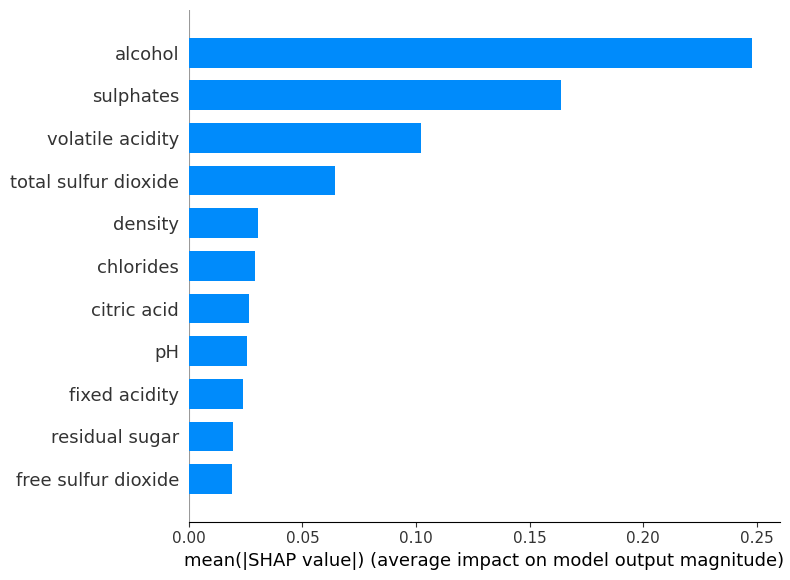

In [ ]:
#@title Plot the feature importance using SHAP (barplot)
shap.summary_plot(shap_values, X_train_scaled[:number_of_rows], feature_names=df.columns.values[np.r_[0:12]], plot_type='bar')

The bar plot above shows the most important feature at the top, which is Alcohol, with the features sorted from most important to least important. We can also see that the top four features have the most impact on the quality of the red wine.